# Install libraries

In [2]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install Ipython
!pip install pyvirtualdisplay
!pip install gym.wrappers
!pip install pygame
!pip install utils

The system cannot find the path specified.


## Install Tile library

In [3]:
!rm -r *
!git clone "https://github.com/hmda77/Machine-Learning-Class"
!mv /content/"Machine-Learning-Class"/RL/MountainCar_Sarsa/tiles3.py /content
!rm -r /content/"Machine-Learning-Class"

'rm' is not recognized as an internal or external command,
operable program or batch file.
'git' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


# Import Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import tiles3 as tc
from tqdm import tqdm 
import utils
import gym
import warnings
import pickle as pk
%matplotlib inline

## render & display libraries

In [6]:
from gym.wrappers import RecordEpisodeStatistics
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

# Video Functions

In [8]:
# display = Display(visible=0, size=(1400, 900))
# display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video' )
    return env


# make enviorment

In [9]:
env = gym.make("MountainCar-v0")
observation = env.reset() 

print("The Action Space is an object of type: {0}\n".format(env.action_space))
print("The shape of the action space is: {0}\n".format(env.action_space.n))
print("The Environment Space is an object of type: {0}\n".format(env.observation_space))
print("The Shape of the dimension Space are: {0}\n".format(env.observation_space.shape))
print("The High values in the observation space are {0}, the low values are {1}\n".format(
    env.observation_space.high, env.observation_space.low))
print("The minimum and maximum car's position are: {0}, {1}\n".format(
    env.observation_space.low[0], env.observation_space.high[0]))
print("The minimum and maximum car's velocity are: {0}, {1}\n".format(
    env.observation_space.low[1], env.observation_space.high[1]))

The Action Space is an object of type: Discrete(3)

The shape of the action space is: 3

The Environment Space is an object of type: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

The Shape of the dimension Space are: (2,)

The High values in the observation space are [0.6  0.07], the low values are [-1.2  -0.07]

The minimum and maximum car's position are: -1.2000000476837158, 0.6000000238418579

The minimum and maximum car's velocity are: -0.07000000029802322, 0.07000000029802322



# Tile Codding Functions

In [10]:
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        POSITION_MIN = -1.2
        POSITION_MAX = 0.6
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07
        
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale])
        
        return np.array(tiles)

In [11]:
# [DO NOT CHANGE]
tests = [[-1.0, 0.01], [0.1, -0.01], [0.2, -0.05], [-1.0, 0.011], [0.2, -0.05]]

mctc = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)

t = []
for test in tests:
    position, velocity = test
    tiles = mctc.get_tiles(position=position, velocity=velocity)
    t.append(tiles)

print("Your results:")
for tiles in t:
    print(tiles)

print()
print("Expected results:")
expected = """[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]
"""
print(expected)

Your results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]

Expected results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]



# Sarsa Algorithm

## Select Action Function

In [12]:
def select_action(Q, tiles, epsilon, num_actions):
    action_values = []
    chosen_action = None

    action_values = np.sum(Q[:, tiles], axis = 1)
    
    if np.random.random() < epsilon:
        chosen_action = np.random.randint(num_actions)
    else:
        chosen_action = np.argmax(action_values)
    
    return chosen_action

## init agents

In [13]:
warnings.filterwarnings("ignore")
all_all_steps=[]
all_all_rewards=[]
num_runs = 4
num_episodes = 10000
agent_infos= [{"num_tilings": 2, "num_tiles": 16, "iht_size": 4096},
              {"num_tilings": 32, "num_tiles": 4, "iht_size": 4096},
              {"num_tilings": 8, "num_tiles": 8, "iht_size": 4096}]

## tilings = 2 tiles = 16 iht_size = 4096

### Train

In [15]:
all_steps = []
all_rewards = []
env = gym.make('MountainCar-v0')
env.reset()
env._max_episode_steps = 1000
agent_info = agent_infos[0]


for n_runs in range(num_runs):
    print('Run: {}'.format(n_runs+1))
    observation = env.reset()
    steps_per_episode = []
    rewards_per_episode = []
    
    #agent init
    num_tilings = agent_info.get("num_tilings", 8)
    num_tiles = agent_info.get("num_tiles", 8)
    iht_size = agent_info.get("iht_size", 4096)
    epsilon = agent_info.get("epsilon", 0.0)
    gamma = agent_info.get("gamma", 1.0)
    alpha = agent_info.get("alpha", 0.5) / num_tilings
    initial_weights = agent_info.get("initial_weights", 0.0)
    num_actions = agent_info.get("num_actions", 3)
    Q = np.ones((num_actions, iht_size)) * initial_weights
    mctc = MountainCarTileCoder(iht_size = iht_size, 
                                          num_tilings = num_tilings, 
                                          num_tiles = num_tiles)
    

    # fisrt step

    position, velocity = observation
    active_tiles = mctc.get_tiles(position = position, velocity = velocity)
    current_action = select_action(Q, active_tiles, epsilon, num_actions)
    last_action = current_action
    previous_tiles = np.copy(active_tiles)

    for t in tqdm(range(num_episodes)):
        n_steps = 0
        rewards = 0
        done = False
        observation = env.reset()
        while not done:
            observation, reward, done, info = env.step(last_action)
            n_steps +=1
            rewards = rewards * gamma + reward

            if not done:
              # agent step
              position, velocity = observation
              active_tiles = mctc.get_tiles(position = position, velocity = velocity)
              current_action = select_action(Q, active_tiles, epsilon, num_actions)
              Q[last_action][previous_tiles] = Q[last_action][previous_tiles] + \
                  alpha*(reward + gamma * Q[current_action][active_tiles] - Q[last_action][previous_tiles])
              last_action = current_action
              previous_tiles = np.copy(active_tiles)
            else:
              Q[last_action][previous_tiles] = Q[last_action][previous_tiles] + \
                  alpha*(reward - Q[last_action][previous_tiles])
      

        steps_per_episode.append(n_steps)
        rewards_per_episode.append(rewards)
    
    all_steps.append(np.array(steps_per_episode))
    all_rewards.append(np.array(rewards_per_episode))

all_all_steps.append(all_steps)
all_all_rewards.append(all_rewards)
env.close()


Run: 1


TypeError: unsupported operand type(s) for *: 'dict' and 'float'

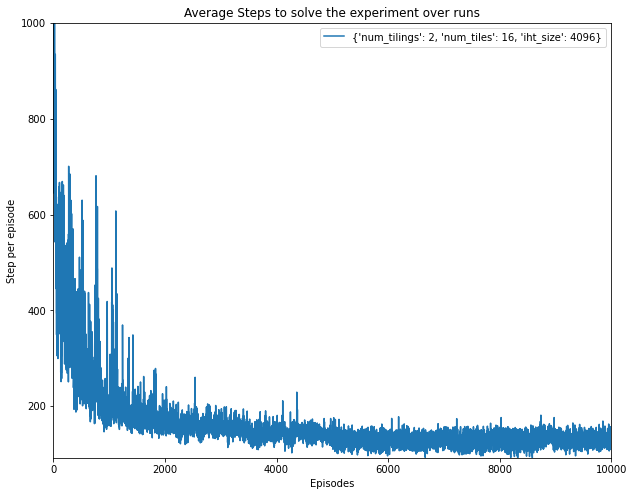

The Minimum number of iterations used to solve the experiment were: 83

The Maximum number of iterations used to solve the experiment were: 1000



In [ ]:
fig=plt.figure(figsize=(10,8))
steps_average = np.mean(np.array(all_steps), axis=0)
plt.plot(steps_average, label = str(agent_info))
plt.xlabel("Episodes")
plt.ylabel("Step per episode", labelpad=4)
plt.xlim(-0.2, num_episodes)
plt.ylim(steps_average.min(), steps_average.max())
plt.title("Average Steps to solve the experiment over runs")
plt.legend()
plt.show()
print("The Minimum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).min()))
print("The Maximum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).max()))

### Test

In [ ]:
num_t = 1000

# Environment
env_to_wrap = gym.make('MountainCar-v0')
env_to_wrap._max_episode_steps = num_t
env = wrap_env(env_to_wrap)

observation = env.reset()
position, velocity = observation
active_tiles = mctc.get_tiles(position = position, velocity = velocity)
last_action = select_action(Q, active_tiles, epsilon, num_actions)
previous_tiles = np.copy(active_tiles)
    
for t in range(num_t):

    env.render()
    observation, reward, done, info = env.step(last_action)

    if not done:
        # agent step
        position, velocity = observation
        active_tiles = mctc.get_tiles(position = position, velocity = velocity)
        last_action = select_action(Q, active_tiles, epsilon, num_actions)
        previous_tiles = np.copy(active_tiles)

    else:
        # agent done
        break


env.close()
env_to_wrap.close()

print("Episode finished after {} timesteps".format(t+1))
show_video()

Episode finished after 141 timesteps


## tilings = 32 tiles = 4 iht_size = 4096

### Train

In [ ]:
all_steps = []
all_rewards = []
env = gym.make('MountainCar-v0')
env.reset()
env._max_episode_steps = 1000
agent_info = agent_infos[1]


for n_runs in range(num_runs):
    print('Run: {}'.format(n_runs+1))
    observation = env.reset()
    steps_per_episode = []
    rewards_per_episode = []
    
    #agent init
    num_tilings = agent_info.get("num_tilings", 8)
    num_tiles = agent_info.get("num_tiles", 8)
    iht_size = agent_info.get("iht_size", 4096)
    epsilon = agent_info.get("epsilon", 0.0)
    gamma = agent_info.get("gamma", 1.0)
    alpha = agent_info.get("alpha", 0.5) / num_tilings
    initial_weights = agent_info.get("initial_weights", 0.0)
    num_actions = agent_info.get("num_actions", 3)
    Q = np.ones((num_actions, iht_size)) * initial_weights
    mctc = MountainCarTileCoder(iht_size = iht_size, 
                                          num_tilings = num_tilings, 
                                          num_tiles = num_tiles)
    

    # fisrt step

    position, velocity = observation
    active_tiles = mctc.get_tiles(position = position, velocity = velocity)
    current_action = select_action(Q, active_tiles, epsilon, num_actions)
    last_action = current_action
    previous_tiles = np.copy(active_tiles)

    for t in tqdm(range(num_episodes)):
        n_steps = 0
        rewards = 0
        done = False
        observation = env.reset()
        while not done:
            observation, reward, done, info = env.step(last_action)
            n_steps +=1
            rewards = rewards * gamma + reward

            if not done:
              # agent step
              position, velocity = observation
              active_tiles = mctc.get_tiles(position = position, velocity = velocity)
              current_action = select_action(Q, active_tiles, epsilon, num_actions)
              Q[last_action][previous_tiles] = Q[last_action][previous_tiles] + \
                  alpha*(reward + gamma * Q[current_action][active_tiles] - Q[last_action][previous_tiles])
              last_action = current_action
              previous_tiles = np.copy(active_tiles)
            else:
              Q[last_action][previous_tiles] = Q[last_action][previous_tiles] + \
                  alpha*(reward - Q[last_action][previous_tiles])
      

        steps_per_episode.append(n_steps)
        rewards_per_episode.append(rewards)
    
    all_steps.append(np.array(steps_per_episode))
    all_rewards.append(np.array(rewards_per_episode))

all_all_steps.append(all_steps)
all_all_rewards.append(all_rewards)
env.close()


Run: 1


100%|██████████| 10000/10000 [06:19<00:00, 26.35it/s]


Run: 2


100%|██████████| 10000/10000 [06:13<00:00, 26.80it/s]


Run: 3


100%|██████████| 10000/10000 [06:17<00:00, 26.49it/s]


Run: 4


100%|██████████| 10000/10000 [06:20<00:00, 26.30it/s]


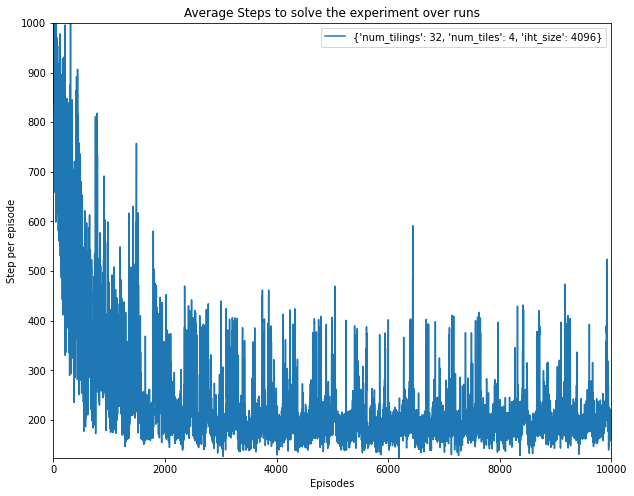

The Minimum number of iterations used to solve the experiment were: 1000

The Maximum number of iterations used to solve the experiment were: 83



In [ ]:
fig=plt.figure(figsize=(10,8))
steps_average = np.mean(np.array(all_steps), axis=0)
plt.plot(steps_average, label = str(agent_info))
plt.xlabel("Episodes")
plt.ylabel("Step per episode", labelpad=4)
plt.xlim(-0.2, num_episodes)
plt.ylim(steps_average.min(), steps_average.max())
plt.title("Average Steps to solve the experiment over runs")
plt.legend()
plt.show()
print("The Minimum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).max()))
print("The Maximum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).min()))

### Test

In [ ]:
num_t = 2000

# Environment
env_to_wrap = gym.make('MountainCar-v0')
env_to_wrap._max_episode_steps = num_t
env = wrap_env(env_to_wrap)

observation = env.reset()
position, velocity = observation
active_tiles = mctc.get_tiles(position = position, velocity = velocity)
last_action = select_action(Q, active_tiles, epsilon, num_actions)
previous_tiles = np.copy(active_tiles)
    
for t in range(num_t):

    env.render()
    observation, reward, done, info = env.step(last_action)

    if not done:
        # agent step
        position, velocity = observation
        active_tiles = mctc.get_tiles(position = position, velocity = velocity)
        last_action = select_action(Q, active_tiles, epsilon, num_actions)
        previous_tiles = np.copy(active_tiles)

    else:
        # agent done
        break


env.close()
env_to_wrap.close()

print("Episode finished after {} timesteps".format(t+1))
show_video()

Episode finished after 161 timesteps


## tilings = 8 tiles = 8 iht_size = 4096

### Train

In [ ]:
all_steps = []
all_rewards = []
env = gym.make('MountainCar-v0')
env.reset()
env._max_episode_steps = 1000
agent_info = agent_infos[2]


for n_runs in range(num_runs):
    print('Run: {}'.format(n_runs+1))
    observation = env.reset()
    steps_per_episode = []
    rewards_per_episode = []
    
    #agent init
    num_tilings = agent_info.get("num_tilings", 8)
    num_tiles = agent_info.get("num_tiles", 8)
    iht_size = agent_info.get("iht_size", 4096)
    epsilon = agent_info.get("epsilon", 0.0)
    gamma = agent_info.get("gamma", 1.0)
    alpha = agent_info.get("alpha", 0.5) / num_tilings
    initial_weights = agent_info.get("initial_weights", 0.0)
    num_actions = agent_info.get("num_actions", 3)
    Q = np.ones((num_actions, iht_size)) * initial_weights
    mctc = MountainCarTileCoder(iht_size = iht_size, 
                                          num_tilings = num_tilings, 
                                          num_tiles = num_tiles)
    

    # fisrt step

    position, velocity = observation
    active_tiles = mctc.get_tiles(position = position, velocity = velocity)
    current_action = select_action(Q, active_tiles, epsilon, num_actions)
    last_action = current_action
    previous_tiles = np.copy(active_tiles)

    for t in tqdm(range(num_episodes)):
        n_steps = 0
        rewards = 0
        done = False
        observation = env.reset()
        while not done:
            observation, reward, done, info = env.step(last_action)
            n_steps +=1
            rewards = rewards * gamma + reward

            if not done:
              # agent step
              position, velocity = observation
              active_tiles = mctc.get_tiles(position = position, velocity = velocity)
              current_action = select_action(Q, active_tiles, epsilon, num_actions)
              Q[last_action][previous_tiles] = Q[last_action][previous_tiles] + \
                  alpha*(reward + gamma * Q[current_action][active_tiles] - Q[last_action][previous_tiles])
              last_action = current_action
              previous_tiles = np.copy(active_tiles)
            else:
              Q[last_action][previous_tiles] = Q[last_action][previous_tiles] + \
                  alpha*(reward - Q[last_action][previous_tiles])
      

        steps_per_episode.append(n_steps)
        rewards_per_episode.append(rewards)
    
    all_steps.append(np.array(steps_per_episode))
    all_rewards.append(np.array(rewards_per_episode))

all_all_steps.append(all_steps)
all_all_rewards.append(all_rewards)
env.close()


Run: 1


100%|██████████| 10000/10000 [03:45<00:00, 44.28it/s]


Run: 2


100%|██████████| 10000/10000 [03:48<00:00, 43.84it/s]


Run: 3


100%|██████████| 10000/10000 [03:52<00:00, 42.95it/s]


Run: 4


100%|██████████| 10000/10000 [03:46<00:00, 44.07it/s]


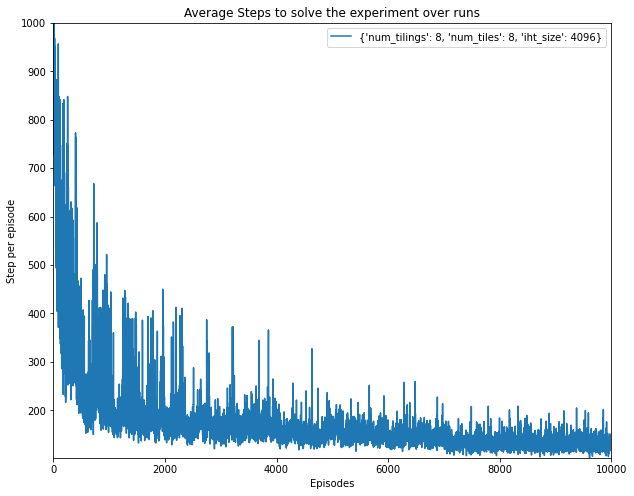

The Minimum number of iterations used to solve the experiment were: 83

The Maximum number of iterations used to solve the experiment were: 1000



In [ ]:
fig=plt.figure(figsize=(10,8))
steps_average = np.mean(np.array(all_steps), axis=0)
plt.plot(steps_average, label = str(agent_info))
plt.xlabel("Episodes")
plt.ylabel("Step per episode", labelpad=4)
plt.xlim(-0.2, num_episodes)
plt.ylim(steps_average.min(), steps_average.max())
plt.title("Average Steps to solve the experiment over runs")
plt.legend()
plt.show()
print("The Minimum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).min()))
print("The Maximum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).max()))

### Test

In [ ]:
num_t = 2000

# Environment
env_to_wrap = gym.make('MountainCar-v0')
env_to_wrap._max_episode_steps = num_t
env = wrap_env(env_to_wrap)

observation = env.reset()
position, velocity = observation
active_tiles = mctc.get_tiles(position = position, velocity = velocity)
last_action = select_action(Q, active_tiles, epsilon, num_actions)
previous_tiles = np.copy(active_tiles)
    
for t in range(num_t):

    env.render()
    observation, reward, done, info = env.step(last_action)

    if not done:
        # agent step
        position, velocity = observation
        active_tiles = mctc.get_tiles(position = position, velocity = velocity)
        last_action = select_action(Q, active_tiles, epsilon, num_actions)
        previous_tiles = np.copy(active_tiles)

    else:
        # agent done
        break


env.close()
env_to_wrap.close()

print("Episode finished after {} timesteps".format(t+1))
show_video()

Episode finished after 107 timesteps


## Results

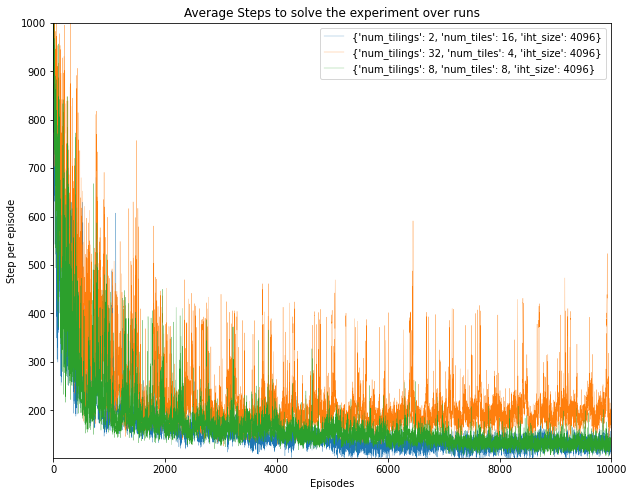

The Minimum number of iterations used to solve the experiment were: 83

The Maximum number of iterations used to solve the experiment were: 1000



In [ ]:
fig=plt.figure(figsize=(10,8))
for i,agent_info  in enumerate(agent_infos):
    steps_average = np.mean(np.array(all_all_steps[i]), axis=0)
    plt.plot(steps_average, label = str(agent_info),lw=0.25)
plt.xlabel("Episodes")
plt.ylabel("Step per episode", labelpad=4)
plt.xlim(-0.2, num_episodes)
plt.ylim(steps_average.min(), np.array(all_all_steps).max())
plt.title("Average Steps to solve the experiment over runs")
plt.legend()
plt.show()
print("The Minimum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).min()))
print("The Maximum number of iterations used to solve the experiment were: {0}\n".format(np.array(all_all_steps).max()))

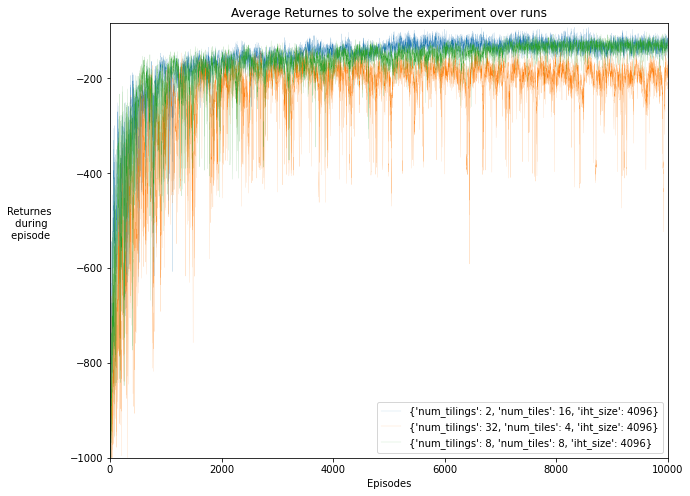

The best Returnes obtained solving the experiment was: -83.0

The Worst Returnes obtained solving the experiment was: -1000.0



In [ ]:
fig=plt.figure(figsize=(10,8))
for i,agent_info  in enumerate(agent_infos):
    rewards_average = np.mean(all_all_rewards[i], axis=0)
    plt.plot(rewards_average, label = str(agent_info),lw=0.1)
plt.xlabel("Episodes")
plt.ylabel("Returnes\n during\n episode" ,rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(np.array(all_all_rewards).min(), np.array(all_all_rewards).max())
plt.title("Average Returnes to solve the experiment over runs")
plt.legend()
plt.show()
print("The best Returnes obtained solving the experiment was: {0}\n".format(np.array(all_all_rewards).max()))
print("The Worst Returnes obtained solving the experiment was: {0}\n".format(np.array(all_all_rewards).min()))